<a href="https://colab.research.google.com/github/ahmadryan/covid19/blob/master/coronavirus_quick_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install geopandas
#!pip install shapely

In [301]:
import pandas as pd
import pylab as pl
import geopandas as gpd
import shapely
import json
import matplotlib as mpl
from numpy import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
#remove warnings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [0]:
# most of the data I grab from online links 
# but the shapefiles downloaded and saved on data/
# the last part of the analysis uses worldbank data 
# which I also downloaded and saved on data/ - that could be changed
#from google.colab import drive

#drive.mount("/content/gdrive")

In [0]:
#cd gdrive/My\ Drive

In [0]:
#cd cv19/covid_data/

In [316]:
%%time
# Read the data from html file which is updated every 5 minutes

india_data = pd.read_html('https://docs.google.com/spreadsheets/d/e/2PACX-1vSc_2y5N0I67wDU38DjDh35IZSIS30rQf7_NYZhtYYGU1jJYT6_kDx4YpF-qw0LSlGsBYP8pqM_a1Pd/pubhtml')

CPU times: user 1min 33s, sys: 71.4 ms, total: 1min 33s
Wall time: 1min 34s


In [491]:
india_data[2].head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,1.0,State,NaN,Confirmed,Recovered,Deaths,Active,Last_Updated_Time
1,2.0,Total,NaN,1139,90,27,1022,29/03/2020 23:57:24
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,Kerala,NaN,202,16,1,185,29/03/2020 18:17:24
4,4.0,Maharashtra,NaN,203,25,7,171,29/03/2020 19:17:24


In [492]:
# Data from the whole country

index = 0
dates = india_data[index]['Unnamed: 3'][2:].values
dates = pd.to_datetime(dates, dayfirst=True)
idx = where( ~isnan(dates ))[0]

df = pd.DataFrame( index=dates[idx])

df['patient_number'] = india_data[index]['Unnamed: 1'][2:idx[-1]+3].values
df['age'] = india_data[index]['Unnamed: 4'][2:idx[-1]+3].values
df['gender'] = india_data[index]['Unnamed: 5'][2:idx[-1]+3].values
df['city'] = india_data[index]['Unnamed: 6'][2:idx[-1]+3].values
df['district'] = india_data[index]['Unnamed: 7'][2:idx[-1]+3].values
df['state'] = india_data[index]['Unnamed: 8'][2:idx[-1]+3].values
df['status'] = india_data[index]['Unnamed: 9'][2:idx[-1]+3].values
df.head()

,patient_number,age,gender,city,district,state,status
2020-01-30,1,20,F,Thrissur,Thrissur,Kerala,Recovered
2020-02-02,2,NaN,NaN,Alappuzha,Alappuzha,Kerala,Recovered
2020-02-03,3,NaN,NaN,Kasaragod,Kasaragod,Kerala,Recovered
2020-03-02,4,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,Recovered
2020-03-02,5,24,M,Hyderabad,Hyderabad,Telangana,Recovered


In [493]:
# Statewise data

df_sw = pd.DataFrame( )
ind = 2
df_sw['states'] = india_data[ind]['Unnamed: 1'][3:].values
df_sw['confirmed'] = india_data[ind]['Unnamed: 3'][3:].values
df_sw['recovered'] = india_data[ind]['Unnamed: 4'][3:].values
df_sw['death'] = india_data[ind]['Unnamed: 5'][3:].values
df_sw['active'] = india_data[ind]['Unnamed: 6'][3:].values

for col in df_sw.columns[1:] :
    df_sw[col] = df_sw[col].astype(float)

df_sw.head()

,states,confirmed,recovered,death,active
0,Kerala,202.0,16.0,1.0,185.0
1,Maharashtra,203.0,25.0,7.0,171.0
2,Karnataka,83.0,5.0,3.0,75.0
3,Telangana,70.0,1.0,1.0,68.0
4,Uttar Pradesh,72.0,11.0,0.0,61.0


In [494]:
# Data related to total tests in the country

index = 4
dates = india_data[index]['Unnamed: 1'][1:].values
dates = pd.to_datetime(dates, dayfirst=True)

df_tt = pd.DataFrame(index=dates)

df_tt['n_samples'] = india_data[index]['Unnamed: 2'][1:].values
df_tt['n_individual'] = india_data[index]['Unnamed: 3'][1:].values
df_tt['n_positive'] = india_data[index]['Unnamed: 4'][1:].values

#df_tt.dropna(inplace=True)

for col in df_tt.columns :
    df_tt[col] = df_tt[col].astype(float)

df_tt.head()

,n_samples,n_individual,n_positive
2020-03-13 00:00:00,6500.0,5900.0,78.0
2020-03-18 18:00:00,13125.0,12235.0,150.0
2020-03-19 10:00:00,13316.0,12426.0,168.0
2020-03-19 18:00:00,14175.0,13285.0,182.0
2020-03-20 10:00:00,14376.0,13486.0,206.0


In [495]:
# Time series of the data

import datetime

ind = 5
india_data[ind].dropna( inplace=True )
first_date = datetime.datetime(year=2020, month=1, day=30).date()
dates = pd.date_range(first_date, periods=len(india_data[ind]['Unnamed: 1'])-1, freq='D')

df_ts = pd.DataFrame(index=dates)
df_ts['daily_confirmed'] = india_data[ind]['Unnamed: 2'][1:].values
df_ts['total_confirmed'] = india_data[ind]['Unnamed: 3'][1:].values
df_ts['daily_recovered'] = india_data[ind]['Unnamed: 4'][1:].values
df_ts['total_recovered'] = india_data[ind]['Unnamed: 5'][1:].values
df_ts['daily_deaths'] = india_data[ind]['Unnamed: 6'][1:].values
df_ts['total_deaths'] = india_data[ind]['Unnamed: 7'][1:].values

for col in df_ts.columns :
    try :

        df_ts[col] = df_ts[col].astype(float)
    except :
        pass

df_ts.head()

,daily_confirmed,total_confirmed,daily_recovered,total_recovered,daily_deaths,total_deaths
2020-01-30,1.0,1.0,0.0,0.0,0.0,0.0
2020-01-31,0.0,1.0,0.0,0.0,0.0,0.0
2020-02-01,0.0,1.0,0.0,0.0,0.0,0.0
2020-02-02,1.0,2.0,0.0,0.0,0.0,0.0
2020-02-03,1.0,3.0,0.0,0.0,0.0,0.0


In [496]:
# Statewise tests

df_swt = pd.DataFrame( )
ind = 7
df_swt['states'] = india_data[ind]['Unnamed: 1'][3:].values
df_swt['total_tests'] = india_data[ind]['Unnamed: 2'][3:].values
df_swt['total_positive'] = india_data[ind]['Unnamed: 3'][3:].values
df_swt['total_negative'] = india_data[ind]['Unnamed: 4'][3:].values
df_swt['total_unconfirmed'] = india_data[ind]['Unnamed: 5'][3:].values

#df_swt.dropna(inplace=True)
for col in df_swt.columns[1:] :
    df_swt[col] = df_swt[col].astype(float)

df_swt.head()

,states,total_tests,total_positive,total_negative,total_unconfirmed
0,Andaman and Nicobar Islands,NaN,NaN,NaN,0.0
1,Andhra Pradesh,496.0,19.0,412.0,65.0
2,Arunachal Pradesh,NaN,NaN,NaN,0.0
3,Assam,NaN,NaN,NaN,0.0
4,Bihar,NaN,NaN,NaN,0.0


In [510]:
# Merge the statewise cases and tests data
df_swtn = pd.merge(df_sw, df_swt)
df_swtn.head()

,states,confirmed,recovered,death,active,total_tests,total_positive,total_negative,total_unconfirmed
0,Kerala,202.0,16.0,1.0,185.0,5432.0,126.0,3768.0,1538.0
1,Maharashtra,203.0,25.0,7.0,171.0,NaN,NaN,NaN,0.0
2,Karnataka,83.0,5.0,3.0,75.0,3076.0,76.0,2763.0,237.0
3,Telangana,70.0,1.0,1.0,68.0,NaN,NaN,NaN,0.0
4,Uttar Pradesh,72.0,11.0,0.0,61.0,NaN,NaN,NaN,0.0


In [498]:
india_data[7]['Unnamed: 2'][3:].values

array([nan, '496', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       '526', nan, '379', nan, '3076', '5432', nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, '2325', nan, '1500', nan, nan, nan,
       nan, nan], dtype=object)

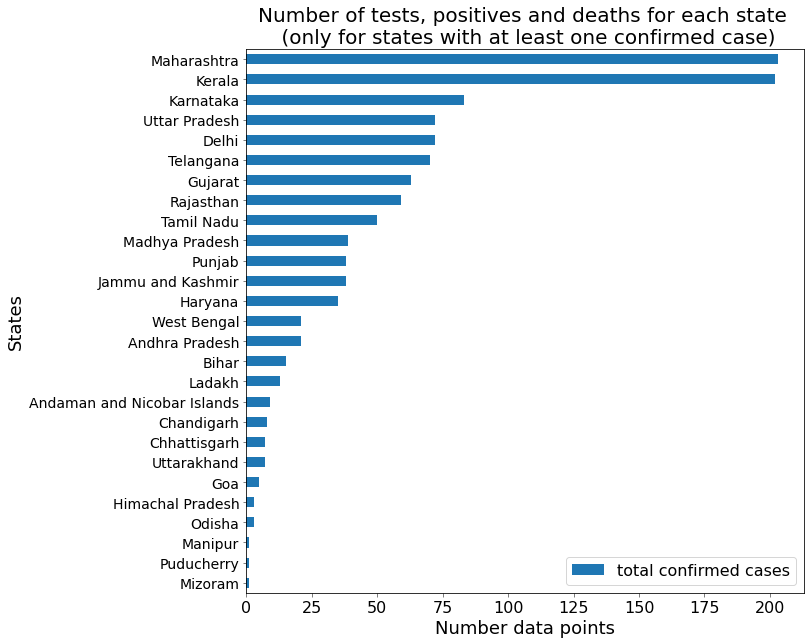

In [502]:
# Statewise number of cases

fig, ax = pl.subplots(1, 1, figsize=(10,20))

df_swtn[df_swtn.confirmed >0].sort_values(by="confirmed").set_index("states")[[
     "confirmed"]].rename({"confirmed":"total confirmed cases"}, axis=1
     ).plot( ax=ax, kind="barh", stacked=False, figsize=(10,10) )

ax.get_xaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=0 )

ax.get_yaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=14, labelrotation=0 )
pl.title("Number of tests, positives and deaths " +
         "for each state \n (only for states with at least one confirmed case)", 
         fontsize=20)
ax.set_ylabel( 'States', fontsize=18)
ax.set_xlabel('Number data points', fontsize=18)
pl.legend(loc=4, fontsize=16)
pl.xscale('linear')

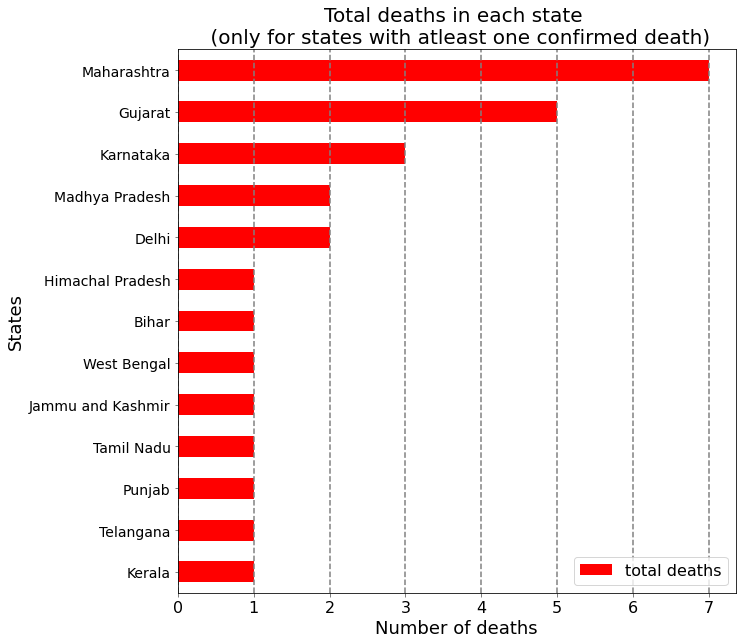

In [503]:
# Statewise number of cases

fig, ax = pl.subplots(1, 1, figsize=(10,20))

df_swtn[df_swtn.death > 0].sort_values(by="death").set_index("states")[[
     "death"]].rename({"death":"total deaths"}, axis=1
     ).plot( ax=ax, kind="barh", stacked=False, figsize=(10,10), color='r')

ax.get_xaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=0 )

ax.get_yaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=14, labelrotation=0 )

for i in range(8) :
    pl.axvline(i, color='gray', ls='--')

pl.title("Total deaths in each state \n (only for states with at" +
         "least one confirmed death)", fontsize=20)
ax.set_ylabel( 'States', fontsize=18)
ax.set_xlabel('Number of deaths', fontsize=18)
pl.legend(loc=4, fontsize=16)
pl.xscale('linear')

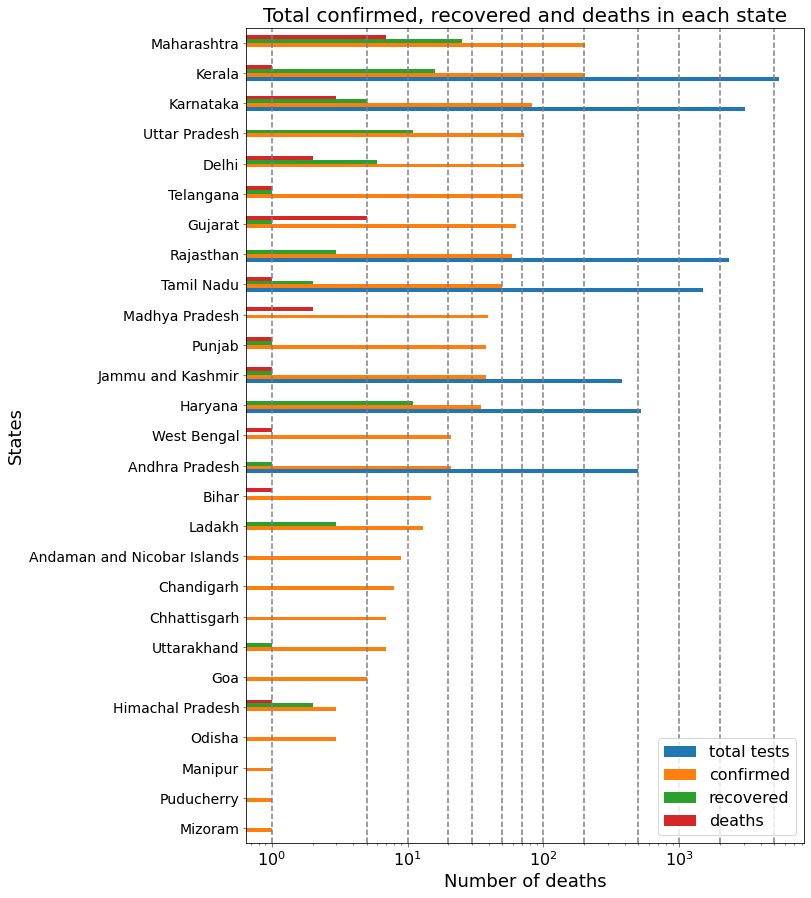

In [508]:
# Statewise number of cases

fig, ax = pl.subplots(1, 1, figsize=(10,20))

df_swtn[df_swtn.confirmed > 0].sort_values(by="confirmed").set_index("states")[[
     "total_tests", "confirmed", "recovered", "death"]].rename({'confirmed': 'confirmed',
                        "recovered":"recovered", "death":"deaths", 
                        "total_tests": "total tests"}, axis=1
     ).plot( ax=ax, kind="barh", stacked=False, figsize=(10,15))

#df_swt[df_swt.total_tests > 0].set_index("states")[[
#     "total_tests"]].rename({'total_tests': 'total number of tests'}, axis=1
#     ).plot( ax=ax, kind="barh", stacked=False, figsize=(10,15))

ax.get_xaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=0 )

ax.get_yaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=14, labelrotation=0 )

x_vals = [1, 5, 10, 20, 30, 50, 70, 100, 200, 500, 1000, 2000, 5000]
for i in x_vals :
    pl.axvline(i, color='gray', ls='--')

pl.title("Total confirmed, recovered and deaths in each state", fontsize=20)
ax.set_ylabel( 'States', fontsize=18)
ax.set_xlabel('Number of deaths', fontsize=18)
pl.legend(loc=4, fontsize=16)
pl.xscale('log')

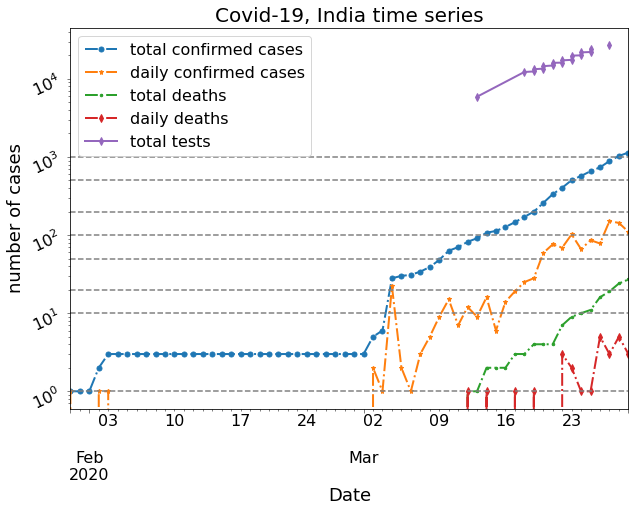

In [509]:
# Number of cases time series for whole country

fig, ax = pl.subplots(1, 1, figsize=(10,10))

df_ts.plot(y='total_confirmed', style="-.", ax=ax, 
           label='total confirmed cases', figsize=(10,7), marker='o', ms=5, lw=2)

df_ts.plot(y='daily_confirmed', style="-.", ax=ax, 
           label='daily confirmed cases', figsize=(10,7), marker='*', ms=5, lw=2)

df_ts.plot(y='total_deaths', style="-.", ax=ax, 
           label='total deaths', figsize=(10,7), marker='.', ms=5, lw=2)

df_ts.plot(y='daily_deaths', style="-.", ax=ax, 
           label='daily deaths', figsize=(10,7), marker='d', ms=5, lw=2)

#df_tt['n_individual']

df_tt.plot(y='n_individual', style="-*", ax=ax, 
           label='total tests', figsize=(10,7), marker='d', ms=5, lw=2)

ax.get_xaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=0 )

ax.get_yaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=25 )

y_vals = [1, 10, 20, 50, 100, 200, 500, 1000]
for i in y_vals :
    pl.axhline(i, color='gray', ls='--')

ax.set_yscale('log')

pl.legend(loc=2, fontsize=16)

pl.ylabel("number of cases", fontsize=18)
pl.xlabel("Date", fontsize=18)
pl.title("Covid-19, India time series", fontsize=20);

In [0]:
# Statewise number of cases

fig, ax = pl.subplots(1, 1, figsize=(10,20))

df_sw[df_sw.confirmed > 0].sort_values(by="confirmed").set_index("states")[[
     "confirmed", "recovered", "death"]].rename({'confirmed': 'total confirmed cases',
                        "recovered":"recovered", "death":"total deaths"}, axis=1
     ).plot( ax=ax, kind="barh", stacked=False, figsize=(10,15))

ax.get_xaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=0 )

ax.get_yaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=14, labelrotation=0 )

x_vals = [1, 5, 10, 20, 30, 50, 70, 100, 200]
for i in x_vals :
    pl.axvline(i, color='gray', ls='--')

pl.title("Total confirmed, recovered and deaths in each state", fontsize=20)
ax.set_ylabel( 'States', fontsize=18)
ax.set_xlabel('Number of deaths', fontsize=18)
pl.legend(loc=4, fontsize=16)
pl.xscale('log')

In [0]:
# JHU database on COVID-19
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
root = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
# get the number of dead people
deaths = pd.read_csv(root + "/time_series_covid19_deaths_global.csv")
#deaths = pd.read_csv(root + "/time_series_19-covid-Deaths.csv")
confirmed = pd.read_csv(root + "/time_series_covid19_confirmed_global.csv")

In [0]:
firstdate = pd.to_datetime(deaths.columns[4])
firstdate

Timestamp('2020-01-22 00:00:00')

In [0]:
# last day contains the cumulative death rate
deaths["totaldeaths"] = deaths[deaths.columns[-1]]
confirmed["totalconfirmed"] = confirmed[confirmed.columns[-1]]

In [0]:
# combine lat and lon to one column
lonlat_deaths = list(zip(deaths.Long, 
                  deaths.Lat))

lonlat_confirmed = list(zip(confirmed.Long, 
                  confirmed.Lat))

In [0]:
# creating the geometry
# Create Point Geometry for based on lonlat column

deaths.reset_index(inplace=True)
deaths = gpd.GeoDataFrame(deaths)
deaths["lonlat"] = lonlat_deaths

deaths['geometry'] = deaths[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [0]:
# creating the geometry
# Create Point Geometry for based on lonlat column

confirmed.reset_index(inplace=True)
confirmed = gpd.GeoDataFrame(confirmed)
confirmed["lonlat"] = lonlat_confirmed

confirmed['geometry'] = confirmed[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [0]:
# I want the data as granular as country. 
# More granular would be great but I could not map it wisely 
# (I would need to find a map of provinces worldwide 
# and do a lot of name matching to merge properly)
deaths["Country/Region"].replace("Mainland China", "China", inplace=True)
deaths["Country/Region"].replace("UK", "United Kingdom", inplace=True)
deaths["Country/Region"].replace("US", "United States", inplace=True)
deaths = deaths.groupby("Country/Region").sum()
deaths['logtotaldeaths'] = np.log10(deaths['totaldeaths'] + 1)

confirmed["Country/Region"].replace("Mainland China", "China", inplace=True)
confirmed["Country/Region"].replace("UK", "United Kingdom", inplace=True)
confirmed["Country/Region"].replace("US", "United States", inplace=True)
confirmed = confirmed.groupby("Country/Region").sum()
confirmed['logtotalconfirmed'] = np.log10(confirmed['totalconfirmed'] + 1)

In [0]:

deaths["firstoccurrence"] = np.zeros(len(deaths)) * np.nan
for i in deaths.index:
    done = False
    for j in range(0, len(deaths.columns)):
        #print(i,j, deaths.iloc[i,j], done)
        if done:
            break
        try :
          pd.to_datetime(deaths.columns[j])
        except ValueError:
          continue
        #print(i, j, deaths.iloc[i,j])
        if (deaths.loc[i][j]) > 0: 
            #print("\t", i,j, deaths.iloc[i,j], done)
            deaths.loc[i, "firstoccurrence"] = pd.to_datetime(deaths.columns[j])          
            done = True

confirmed["firstoccurrence"] = np.zeros(len(confirmed)) * np.nan
for i in confirmed.index:
    done = False
    for j in range(0, len(confirmed.columns)):
        #print(i,j, confirmed.iloc[i,j], done)
        if done:
            break
        try :
          pd.to_datetime(confirmed.columns[j])
        except ValueError:
          continue
        #print(i, j, confirmed.iloc[i,j])
        if (confirmed.loc[i][j]) > 0: 
            #print("\t", i,j, confirmed.iloc[i,j], done)
            confirmed.loc[i, "firstoccurrence"] = pd.to_datetime(confirmed.columns[j])          
            done = True

In [0]:
print ("as of {}".format(pd.to_datetime("today").date()))
print ("number of countries in the database {:d}".format(len(deaths)))
print ("number of countries with at least 1 death {:d}".format(
    (deaths.totaldeaths > 0).sum()))
print ("number of countries with at least 1 confirmed case {:d}".format(
    (confirmed.totalconfirmed > 0).sum()))

as of 2020-03-28
number of countries in the database 176
number of countries with at least 1 death 108
number of countries with at least 1 confirmed case 176


In [0]:
# how many days are in the database?
maxday = pd.Timedelta(pd.to_datetime("today").normalize() - pd.to_datetime("01/01/2020"))
maxday -= pd.Timedelta(2, unit="day")
maxday

Timedelta('85 days 00:00:00')

In [0]:
# it will be convenient to have the log number, instead of the natural number, 
# or maps will have too much contrast 
# I am adding it to columns with columname the date, but as a string
def addlogbydate(df):
  for d in df.columns:
    try :
      pd.to_datetime(d)
    except ValueError:
      continue
    df[pd.to_datetime(d).strftime('%Y-%m-%d')] = df[d]
  return df

In [0]:
deaths = addlogbydate(deaths).reset_index()
confirmed = addlogbydate(confirmed).reset_index()

In [0]:
def get_dataset(df=None, day=None, key="firstoccurrence"):
    ''' this produces a geodataframe by country with the number of deaths by day
    df: the dataframe with covid data
    day: the date to be plotted in days since 01/01/2020
    key: only used if day is None - name of a column, it will extract data for that column
    returns the dataframe combined with a world map and converted to a dataframe, the column used'''
    if day is None:
      newt = key
      print('Day was None')
    else:
      newt = (pd.to_datetime("1/1/2020") + pd.Timedelta(day, "D")).strftime('%Y-%m-%d')

    if newt not in df.columns:
        raise ValueError('Number out of range. Please ensure that the number\
        of days lies between 0 and number of days passed since January 1st, 2020')
        return
        #newt = firstdate.strftime('%Y-%m-%d')
    
    worlddeaths = world[["NAME", "geometry"]].merge(
        df[["Country/Region", newt]], 
        left_on="NAME", right_on="Country/Region", how="left")
    
    worlddeaths = gpd.GeoDataFrame(worlddeaths.groupby("NAME").sum().reset_index(
    ).merge(worlddeaths[["NAME", "geometry"]].drop_duplicates(subset="NAME"), 
            on="NAME", how="left"))
    worlddeaths[newt] = worlddeaths[newt].fillna(0)
    
    return worlddeaths, newt
#get_dataset(1)

In [0]:
# from the JHU database
infected = gpd.GeoDataFrame(pd.read_csv(root + 
                                        "time_series_covid19_confirmed_global.csv"))

In [0]:
infected = infected.groupby("Country/Region").sum()
# number of dates in the database
N = infected.shape[1] - 2

In [0]:
infected.reset_index(inplace=True)
infected["Country/Region"].replace("Mainland China", "China", inplace=True)
infected["Country/Region"].replace("UK", "United Kingdom", inplace=True)
infected["Country/Region"].replace("US", "United States", inplace=True)

In [0]:
#world = gpd.GeoDataFrame.from_file("TM_WORLD_BORDERS_SIMPL-0.3.shp")

#infected["totalinfected"] = infected[infected.columns[-1]]
#infected = addlogbydate(infected)

#data, key = get_dataset(day=24, df=infected)
#data = gpd.GeoDataFrame(data.groupby("NAME").sum().reset_index(
#    ).merge(data[["NAME", "geometry"]].drop_duplicates(subset="NAME"), 
#            on="NAME", how="left")).plot()

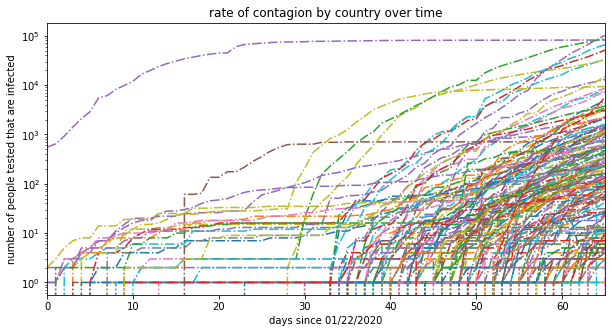

In [0]:
# the rate of contagion by country over time
def getcountry (df, country):
  return df[df["Country/Region"] == country].set_index("Country/Region")[
                  df.columns[3:N+3]].T.reset_index()

fig, ax = pl.subplots(1, 1, figsize=(10,5))
for country in infected["Country/Region"].values:

  tmp = getcountry(infected, country)#.set_index("Country/Region")
  tmp.plot(style="-.", 
           ax=ax, label=None,
           legend=False,
           #label=country, 
           figsize=(10,5))
pl.yscale("log")
pl.ylabel("number of people tested that are infected")
pl.xlabel("days since 01/22/2020")
pl.title("rate of contagion by country over time");

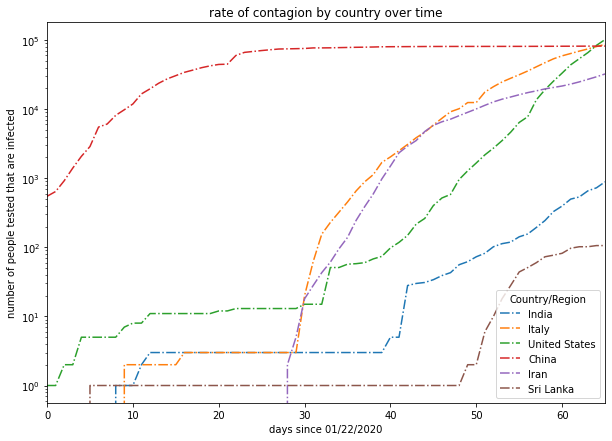

In [0]:
india = getcountry(infected, 'India')
italy = getcountry(infected, 'Italy')
us = getcountry(infected, 'United States')
china = getcountry(infected, 'China')
iran = getcountry(infected, 'Iran')
srl = getcountry(infected, 'Sri Lanka')

fig, ax = pl.subplots(1, 1, figsize=(10,7))

india.plot(style="-.", ax=ax,label='India', figsize=(10,7))
italy.plot(style="-.", ax=ax, label='Italy', figsize=(10,7))
us.plot(style="-.", ax=ax, label='US', figsize=(10,7))
china.plot(style="-.", ax=ax, label='China', figsize=(10,7))
iran.plot(style="-.", ax=ax, label='Iran', figsize=(10,7))
srl.plot(style="-.", ax=ax, label='Sri Lanka', figsize=(10,7))

pl.yscale("log")
pl.ylabel("number of people tested that are infected")
pl.xlabel("days since 01/22/2020")
pl.title("rate of contagion by country over time");
#plt.figure()
#plt.plot(india)

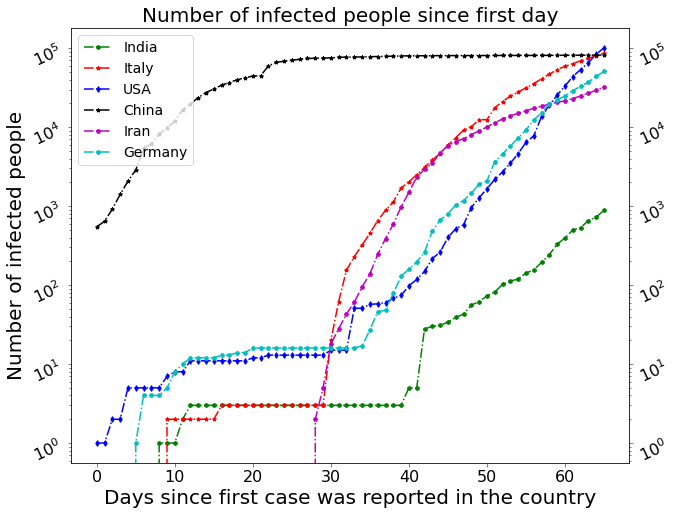

In [0]:
india = getcountry(infected, 'India')
italy = getcountry(infected, 'Italy')
us = getcountry(infected, 'United States')
china = getcountry(infected, 'China')
iran = getcountry(infected, 'Iran')
germany = getcountry(infected, 'Germany')

idx_ind = where( india.India >= 0 )[0]
idx_itl = where( italy.Italy >= 0 )[0]
idx_usa = where( us['United States'] >= 0 )[0]
idx_chn = where( china.China >= 0 )[0]
idx_irn = where( iran.Iran >= 0 )[0]
idx_grn = where( germany.Germany >= 0 )[0]

ls = '-.'
ms = 4

fig, ax = pl.subplots(1, 1, figsize=(10,8))

ax.plot( arange(len(idx_ind)), india.India[idx_ind], 'gh', label='India', ms=ms, ls=ls )
ax.plot( arange(len(idx_itl)), italy.Italy[idx_itl],  'r*', label='Italy', ms=ms, ls=ls )
ax.plot( arange(len(idx_usa)), us['United States'][idx_usa], 'bd', label='USA', ms=ms, ls=ls )
ax.plot( arange(len(idx_chn)), china.China[idx_chn],  'k*', label='China', ms=ms, ls=ls )
ax.plot( arange(len(idx_irn)), iran.Iran[idx_irn], 'mH', label='Iran', ms=ms, ls=ls )
ax.plot( arange(len(idx_grn)), germany.Germany[idx_grn], 'cH', label='Germany', ms=ms, ls=ls )

ax.set_ylabel('Number of infected people', fontsize=20)
ax.set_xlabel('Days since first case was reported in the country', fontsize=20)
ax.set_title('Number of infected people since first day', fontsize=20)
ax.set_yscale('log')

ax.get_xaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=0 )

ax.get_yaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, labelright=True, right=True, width=.5, labelsize=16, labelrotation=25 )

ax.legend(loc=2, fontsize=14);


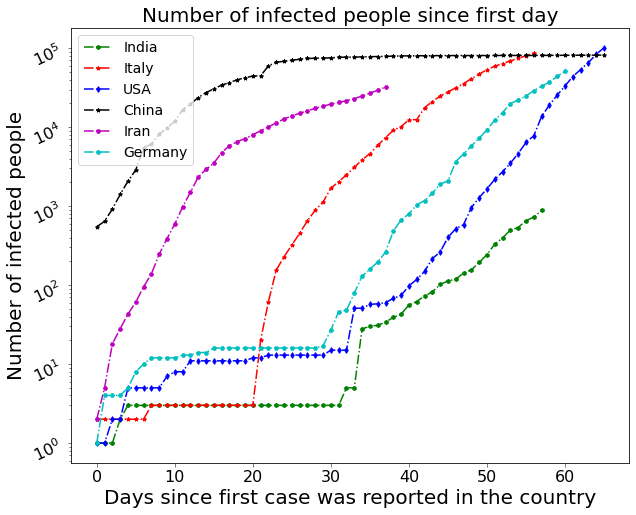

In [0]:
india = getcountry(infected, 'India')
italy = getcountry(infected, 'Italy')
us = getcountry(infected, 'United States')
china = getcountry(infected, 'China')
iran = getcountry(infected, 'Iran')
germany = getcountry(infected, 'Germany')

idx_ind = where( india.India > 0 )[0]
idx_itl = where( italy.Italy > 0 )[0]
idx_usa = where( us['United States'] > 0 )[0]
idx_chn = where( china.China > 0 )[0]
idx_irn = where( iran.Iran > 0 )[0]
idx_grn = where( germany.Germany > 0 )[0]

ls = '-.'
ms = 4

fig, ax = pl.subplots(1, 1, figsize=(10,8))

ax.plot( arange(len(idx_ind)), india.India[idx_ind], 'gh', label='India', ms=ms, ls=ls )
ax.plot( arange(len(idx_itl)), italy.Italy[idx_itl],  'r*', label='Italy', ms=ms, ls=ls )
ax.plot( arange(len(idx_usa)), us['United States'][idx_usa], 'bd', label='USA', ms=ms, ls=ls )
ax.plot( arange(len(idx_chn)), china.China[idx_chn],  'k*', label='China', ms=ms, ls=ls )
ax.plot( arange(len(idx_irn)), iran.Iran[idx_irn], 'mH', label='Iran', ms=ms, ls=ls )
ax.plot( arange(len(idx_grn)), germany.Germany[idx_grn], 'cH', label='Germany', ms=ms, ls=ls )

ax.set_ylabel('Number of infected people', fontsize=20)
ax.set_xlabel('Days since first case was reported in the country', fontsize=20)
ax.set_title('Number of infected people since first day', fontsize=20)
ax.set_yscale('log')

ax.get_xaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=0 )

ax.get_yaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=25 )

ax.legend(loc=2, fontsize=14);


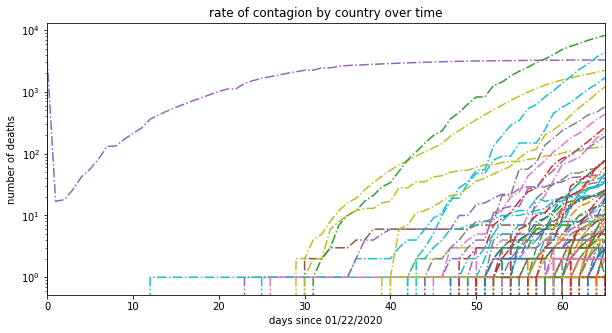

In [0]:
# the rate of contagion by country over time
def getcountry (df, country):
  return df[df["Country/Region"] == country].set_index("Country/Region")[
                  df.columns[3:N+3]].T.reset_index()

fig, ax = pl.subplots(1, 1, figsize=(10,5))
for country in deaths["Country/Region"].values:

  tmp = getcountry(deaths, country)#.set_index("Country/Region")
  tmp.plot(style="-.", 
           ax=ax, label=None,
           legend=False,
           #label=country, 
           figsize=(10,5))
pl.yscale("log")
pl.ylabel("number of deaths")
pl.xlabel("days since 01/22/2020")
pl.title("rate of contagion by country over time");

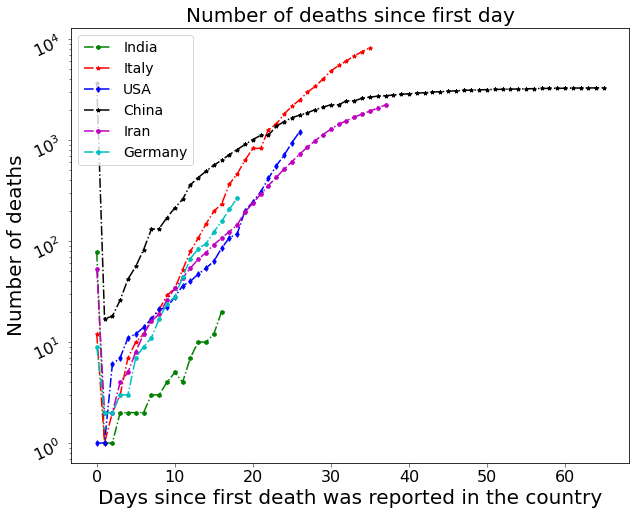

In [0]:
india = getcountry(deaths, 'India')
italy = getcountry(deaths, 'Italy')
us = getcountry(deaths, 'United States')
china = getcountry(deaths, 'China')
iran = getcountry(deaths, 'Iran')
germany = getcountry(deaths, 'Germany')

idx_ind = where( india.India > 0 )[0]
idx_itl = where( italy.Italy > 0 )[0]
idx_usa = where( us['United States'] > 0 )[0]
idx_chn = where( china.China > 0 )[0]
idx_irn = where( iran.Iran > 0 )[0]
idx_grn = where( germany.Germany > 0 )[0]

ls = '-.'
ms = 4

fig, ax = pl.subplots(1, 1, figsize=(10,8))

ax.plot( arange(len(idx_ind)), india.India[idx_ind], 'gh', label='India', ms=ms, ls=ls )
ax.plot( arange(len(idx_itl)), italy.Italy[idx_itl],  'r*', label='Italy', ms=ms, ls=ls )
ax.plot( arange(len(idx_usa)), us['United States'][idx_usa], 'bd', label='USA', ms=ms, ls=ls )
ax.plot( arange(len(idx_chn)), china.China[idx_chn],  'k*', label='China', ms=ms, ls=ls )
ax.plot( arange(len(idx_irn)), iran.Iran[idx_irn], 'mH', label='Iran', ms=ms, ls=ls )
ax.plot( arange(len(idx_grn)), germany.Germany[idx_grn], 'cH', label='Germany', ms=ms, ls=ls )

ax.set_ylabel('Number of deaths', fontsize=20)
ax.set_xlabel('Days since first death was reported in the country', fontsize=20)
ax.set_title('Number of deaths since first day', fontsize=20)
ax.set_yscale('log')

ax.get_xaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=0 )

ax.get_yaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=25 )

ax.legend(loc=2, fontsize=14);


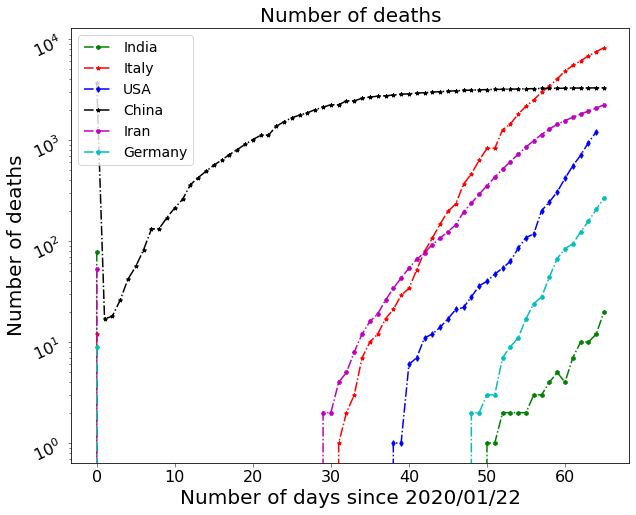

In [0]:
india = getcountry(deaths, 'India')
italy = getcountry(deaths, 'Italy')
us = getcountry(deaths, 'United States')
china = getcountry(deaths, 'China')
iran = getcountry(deaths, 'Iran')
germany = getcountry(deaths, 'Germany')

idx_ind = where( india.India >= 0 )[0]
idx_itl = where( italy.Italy >= 0 )[0]
idx_usa = where( us['United States'] >= 0 )[0]
idx_chn = where( china.China >= 0 )[0]
idx_irn = where( iran.Iran >= 0 )[0]
idx_grn = where( germany.Germany >= 0 )[0]

ls = '-.'
ms = 4

fig, ax = pl.subplots(1, 1, figsize=(10,8))

ax.plot( arange(len(idx_ind)), india.India[idx_ind], 'gh', label='India', ms=ms, ls=ls )
ax.plot( arange(len(idx_itl)), italy.Italy[idx_itl],  'r*', label='Italy', ms=ms, ls=ls )
ax.plot( arange(len(idx_usa)), us['United States'][idx_usa], 'bd', label='USA', ms=ms, ls=ls )
ax.plot( arange(len(idx_chn)), china.China[idx_chn],  'k*', label='China', ms=ms, ls=ls )
ax.plot( arange(len(idx_irn)), iran.Iran[idx_irn], 'mH', label='Iran', ms=ms, ls=ls )
ax.plot( arange(len(idx_grn)), germany.Germany[idx_grn], 'cH', label='Germany', ms=ms, ls=ls )

ax.set_ylabel('Number of deaths', fontsize=20)
ax.set_xlabel('Number of days since 2020/01/22', fontsize=20)
ax.set_title('Number of deaths', fontsize=20)
ax.set_yscale('log')

ax.get_xaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=0 )

ax.get_yaxis().set_tick_params( which='both', direction='out',
labelbottom=True, bottom=True, width=.5, labelsize=16, labelrotation=25 )

ax.legend(loc=2, fontsize=14);